In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import spacy
import re

In [51]:
df = pd.read_csv('AnimeData_280724.csv')

In [52]:
df.head()

,Title,Episodes,Release Year,Status,Genres,Studio,Source,Demographic,Themes,Synopsis,Voters,Rating
0,Shingeki no Kyojin,25.0,2013,Finished,"Action, Award Winning, Drama, Suspense",Wit Studio,Manga,Shounen,NaN,"Centuries ago, mankind was slaughtered to near...",NaN,8.55
1,Fullmetal Alchemist: Brotherhood,64.0,2009,Finished,"Action, Adventure, Drama, Fantasy",Bones,Manga,Shounen,NaN,After a horrific alchemy experiment goes wrong...,NaN,NaN
2,One Punch Man,12.0,2015,Finished,"Action, Comedy",Madhouse,Web manga,Seinen,NaN,The seemingly unimpressive Saitama has a rathe...,NaN,8.49
3,Sword Art Online,25.0,2012,Finished,"Action, Adventure, Fantasy, Romance",A-1 Pictures,Light novel,NaN,NaN,Ever since the release of the innovative Nerve...,NaN,NaN
4,Kimetsu no Yaiba,26.0,2019,Finished,"Action, Award Winning, Fantasy",ufotable,Manga,Shounen,NaN,"Ever since the death of his father, the burden...",NaN,8.46


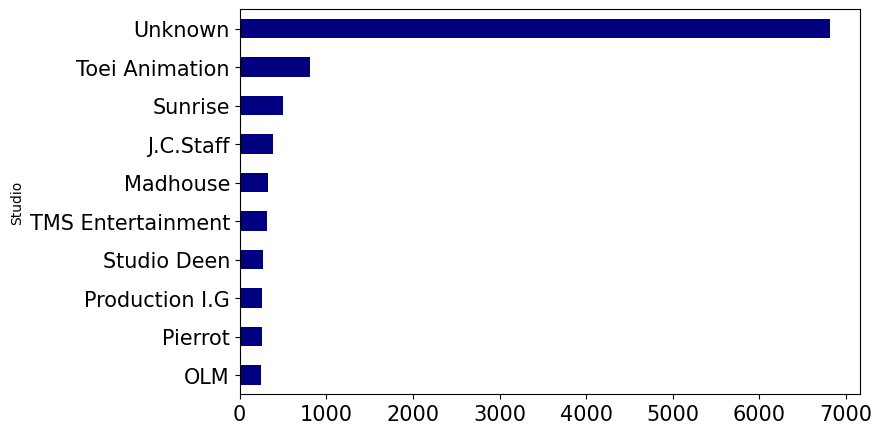

In [53]:
# Count the occurrences of each unique value in the 'Studio' column
# Select the top 10 most frequent studios
# Plot these counts as a horizontal bar chart
df['Studio'].value_counts()[0:10].plot(
    kind='barh',               # Create a horizontal bar chart
    figsize=[8,5],             # Set the figure size to 8x5 inches
    fontsize=15,               # Set the font size of the labels to 15
    color='navy'               # Set the color of the bars to navy
).invert_yaxis()               # Invert the y-axis to have the highest values on top


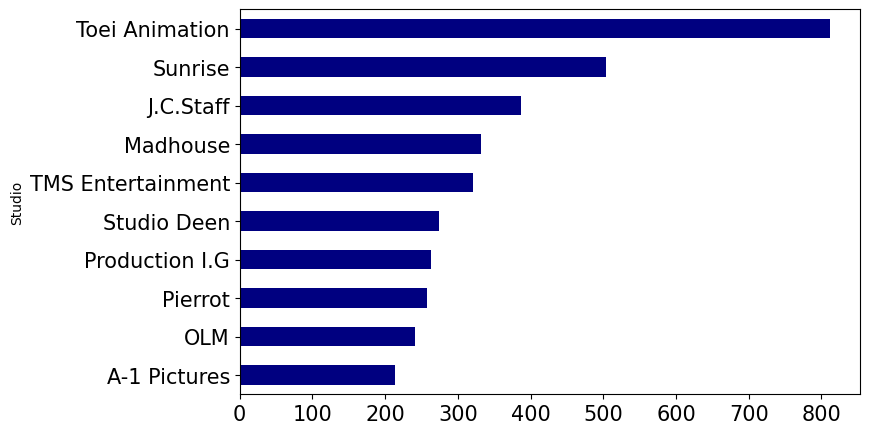

In [54]:
# Filter out rows where the 'Studio' column has the value 'unknown'
filtered_df = df[(df['Studio'] != 'Unknown')]

# Count occurrences of each unique value in the filtered 'Studio' column
# Select the top 10 most frequent studios
filtered_df['Studio'].value_counts()[0:10].plot(
    kind='barh',               # Create a horizontal bar chart
    figsize=[8,5],             # Set the figure size to 8x5 inches
    fontsize=15,               # Set the font size of the labels to 15
    color='navy'               # Set the color of the bars to navy
).invert_yaxis()               # Invert the y-axis to have the highest values on top


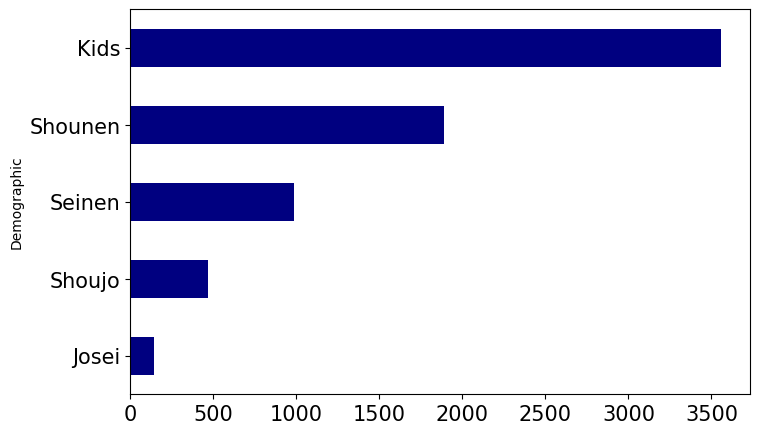

In [55]:
# Count the occurrences of each unique value in the 'Demographic' column
# Select the top 10 most frequent demographics
df['Demographic'].value_counts()[0:10].plot(
    kind='barh',               # Create a horizontal bar chart
    figsize=[8,5],             # Set the figure size to 8x5 inches
    fontsize=15,               # Set the font size of the labels to 15
    color='navy'               # Set the color of the bars to navy
).invert_yaxis()               # Invert the y-axis to have the highest values on top


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19935 entries, 0 to 19934
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         19935 non-null  object 
 1   Episodes      10909 non-null  float64
 2   Release Year  19935 non-null  int64  
 3   Status        19559 non-null  object 
 4   Genres        19935 non-null  object 
 5   Studio        18932 non-null  object 
 6   Source        17756 non-null  object 
 7   Demographic   7042 non-null   object 
 8   Themes        0 non-null      float64
 9   Synopsis      19930 non-null  object 
 10  Voters        8295 non-null   float64
 11  Rating        625 non-null    float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.8+ MB


In [7]:
df[df.duplicated()]

,Title,Episodes,Release Year,Status,Genres,Studio,Source,Demographic,Themes,Synopsis,Voters,Rating


In [8]:
df[df.duplicated(subset=['Title'], keep=False)].sort_values(by='Title')['Synopsis'].to_list()

["Anime Project based on the game of the same name.\r\n\r\nAfter the death of Felicidad's ruler, the despotic overlord Glaza seizes power and imposes an oppressive regime on the world's inhabitants. As Ten and his fellow Farmagia friends, command an army of monsters as you explore and battle across the treacherous lands of the Underworld, collecting resources to take back to your farm. There you'll upgrade your skills as a Farmagia, growing more monsters to nurture, and developing their new traits to aid your battle against Glaza and the Oración Seis.\r\n\r\n(Source: Marvelous USA)",
 "Anime Project based on the game of the same name.\r\n\r\nAfter the death of Felicidad's ruler, the despotic overlord Glaza seizes power and imposes an oppressive regime on the world's inhabitants. As Ten and his fellow Farmagia friends, command an army of monsters as you explore and battle across the treacherous lands of the Underworld, collecting resources to take back to your farm. There you'll upgrade

In [9]:
df.shape

(19935, 12)

In [10]:
df.drop_duplicates(subset=['Title'], keep='last', inplace=True)
df.shape

(19931, 12)

In [11]:
df.fillna('', inplace=True)

In [12]:
df.reset_index(drop=True, inplace=True)

In [14]:
# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Ensure 'Genres' column is of type string
df['Genres'] = df['Genres'].astype(str)

# Replace commas in the 'Genres' column with spaces
df['Genres'] = df['Genres'].str.replace(',', ' ')

def preprocess_text(text):
    """
    Preprocess text by lemmatizing and removing stop words and non-alphabetic tokens.

    Parameters:
    text (str): The text to preprocess.

    Returns:
    str: The preprocessed text.
    """
    # Create a SpaCy document object
    doc = nlp(text)
    
    # Lemmatize tokens, convert to lowercase, and filter out stop words and non-alphabetic tokens
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    
    # Join the tokens into a single string
    return ' '.join(tokens)

# Apply the preprocessing function to the 'Genres' column
df['Genres'] = df['Genres'].apply(preprocess_text)

# Apply the preprocessing function to the 'Synopsis' column
df['Synopsis'] = df['Synopsis'].apply(preprocess_text)


In [15]:
#Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the textual df
tfidf_matrix = vectorizer.fit_transform(df['Genres']+ " " + df['Synopsis'])


In [27]:
# Compute the cosine similarity matrix for the TF-IDF matrix
# The similarity matrix is a square matrix where each element [i, j] represents
# the cosine similarity between item i and item j based on their TF-IDF representations.
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [46]:
def get_top_5_recommendations(title_name, df, similarity_matrix):
    """
    Get the top 5 recommended titles based on similarity to a given title.

    Parameters:
    title_name (str): The title for which recommendations are to be made.
    df (pd.DataFrame): DataFrame containing the titles and other information.
    similarity_matrix (np.ndarray): Matrix where each element [i, j] represents the similarity between title i and title j.

    Returns:
    list: A list of the top 5 recommended titles, excluding the input title and ensuring no similar titles are included.
    
    Raises:
    ValueError: If the input title is not found in the DataFrame.
    """
    # Ensure the title exists in the DataFrame
    if title_name not in df['Title'].values:
        raise ValueError("Title not found in the DataFrame")

    # Find the index of the input title
    item_index = df[df['Title'] == title_name].index[0]

    # Get the list of titles sorted by similarity
    titles = df.iloc[similarity_matrix[item_index].argsort()[::-1]]['Title'].to_list()

    # Initialize list to store the top 5 recommendations
    recommendations = []

    # Get the top 5 recommendations
    for title in titles:
        if title_name not in title and title_name != title:
            recommendations.append(title)
        if len(recommendations) == 5:
            break

    return recommendations

In [47]:
# Example usage
# df is your DataFrame
# similarity_matrix is the computed similarity matrix
# title_name is the title you want recommendations for
recommendations = get_top_5_recommendations('Shingeki no Kyojin', df, similarity_matrix)
recommendations

['Shingeki! Kyojin Chuugakkou',
 'Shingeki no Kyotou',
 'Kidou Senshi Zeta Gundam',
 'Kiitarou Shounen no Youkai Enikki',
 'Yuri Kuma Arashi']